# Entrenamiento para Modelos RL

## Librerias

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from gym_envs import make_galaxian_env
from utils import set_global_seed, get_seed
from models import DQN, DuelingDQN
from replay_buffer import ReplayBuffer
from policies import DQNPolicy

import matplotlib.pyplot as plt

## Configuración de CUDA

In [2]:
seed = get_seed()
if seed is not None:
    print(f"Usando SEED global = {seed}")
    set_global_seed(seed)
else:
    # Crear una semilla aleatoria y usarla
    seed = np.random.randint(0, 10000)
    set_global_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Usando SEED global = 42
Using GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Creación de Entorno con procesamiento

In [3]:
# Crear entorno con preprocesamiento estilo DeepMind
env = make_galaxian_env(
    render_mode=None,           # para entrenamiento, más rápido
    deepmind_wrappers=True,     # aplica AtariPreprocessing + FrameStackObservation
    frame_stack=4,              # número de frames a apilar
)

# Probar entorno
obs, info = env.reset()
print("Tipo de obs:", type(obs))
obs_arr = np.array(obs, copy=False)
print("Shape de obs (np.array):", obs_arr.shape)
print("Dtype de obs:", obs_arr.dtype)

num_actions = env.action_space.n
print("Número de acciones:", num_actions)

Tipo de obs: <class 'numpy.ndarray'>
Shape de obs (np.array): (4, 84, 84)
Dtype de obs: uint8
Número de acciones: 6


## Helper para convertir obs → estado (C, H, W)

In [4]:
def obs_to_state(obs) -> np.ndarray:
    """
    Convierte la observación del entorno (que puede venir como LazyFrames
    u otro tipo) a un np.ndarray con shape (C, H, W).
    Args:
        obs: observación del entorno
    Returns:
        np.ndarray con shape (C, H, W)
    """
    arr = np.array(obs, copy=False)

    if arr.ndim == 3:
        # Casos típicos:
        # - (H, W, C)
        # - (C, H, W)
        H, W = 84, 84  # por diseño de AtariPreprocessing

        if arr.shape[0] == H and arr.shape[1] == W:
            # (H, W, C) -> (C, H, W)
            arr = np.transpose(arr, (2, 0, 1))
        elif arr.shape[1] == H and arr.shape[2] == W:
            # ya está en (C, H, W), no tocamos
            pass
        else:
            raise ValueError(f"Shape de obs inesperado: {arr.shape}")
    elif arr.ndim == 2:
        # 1 frame (H, W) -> (1, H, W)
        arr = arr[None, ...]
    else:
        raise ValueError(f"Obs con ndim no soportado: {arr.ndim}")

    return arr

## Función de entrenamiento

In [5]:
def train_dqn_variant(
    model_class,                 # DQN o DuelingDQN
    num_episodes: int,
    max_steps: int,
    label: str = "DQN",
    seed_base: int | None = None,
    print_every: int = 10,
    checkpoint_every: int = 100,
):
    """
    Entrena un modelo DQN-like (DQN o DuelingDQN) en Galaxian.
    Crea:
        - nuevo env
        - nuevo modelo online/target
        - nuevo replay buffer
        - su propio loop de entrenamiento

    Args:
        - model_class: clase del modelo a usar (DQN o DuelingDQN)
        - num_episodes: número de episodios para entrenar
        - max_steps: número máximo de pasos por episodio
        - label: etiqueta para identificar la variante en los logs
        - seed_base: semilla base para reproducibilidad (opcional)

    Returns:
        - lista de recompensas por episodio
        - lista de longitudes de episodio
    """
    # Crear entorno DeepMind preprocesado
    env = make_galaxian_env(
        render_mode=None,           # para entrenamiento, más rápido
        deepmind_wrappers=True,     # aplica AtariPreprocessing + FrameStackObservation
        frame_stack=4,              # número de frames a apilar
    )

    # Reset inicial para definir input shape
    if seed_base is not None:
        obs, _ = env.reset(seed=seed_base)
    else:
        obs, _ = env.reset()

    state = obs_to_state(obs)
    in_channels = state.shape[0]
    num_actions = env.action_space.n

    # Redes online y target
    online_net = model_class(in_channels=in_channels, num_actions=num_actions).to(device)
    target_net = model_class(in_channels=in_channels, num_actions=num_actions).to(device)
    target_net.load_state_dict(online_net.state_dict())
    target_net.eval()

    # Optimizador
    optimizer = optim.Adam(online_net.parameters(), lr=1e-4)

    # Hiperparámetros
    gamma = 0.99
    batch_size = 32

    # Cálculo de buffer_capacity basado en max_steps
    buffer_capacity = int(min(max_steps // 2, 200_000))
    buffer_capacity = max(buffer_capacity, 50_000)

    # Empezar a aprender cuando ya haya suficiente diversidad en el buffer
    # aprox. 10% de buffer o 1% de max_steps, lo que sea mayor
    start_learning_after = max(buffer_capacity // 10, max_steps // 100, 5_000)

    # Frecuencia de actualización de la red target: ~5% de max_steps, mínimo 5k
    target_update_freq = max(max_steps // 20, 5_000)

    # Decaimiento de epsilon: ~40% de los steps totales
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay_steps = int(max_steps * 0.5)

    # Replay buffer
    obs_shape = state.shape
    replay_buffer = ReplayBuffer(
        capacity=buffer_capacity,
        obs_shape=obs_shape,
        device=device,
        dtype=np.uint8,
    )

    print(f"[{label}] max_steps={max_steps}")
    print(f"[{label}] buffer_capacity={buffer_capacity}")
    print(f"[{label}] start_learning_after={start_learning_after}")
    print(f"[{label}] target_update_freq={target_update_freq}")
    print(f"[{label}] epsilon_decay_steps={epsilon_decay_steps}")

    def epsilon_by_step(step: int) -> float:
        """
        Calcula el valor de epsilon para el paso dado.
        Args:
            step: paso global actual
        Returns:
            valor de epsilon
        """
        if step >= epsilon_decay_steps:
            return epsilon_end
        else:
            return epsilon_start - (epsilon_start - epsilon_end) * (step / epsilon_decay_steps)

    def select_action(state: np.ndarray, step: int) -> int:
        """
        Selecciona una acción usando una política epsilon-greedy.
        Args:
            state: estado actual
            step: paso global actual
        Returns:
            acción seleccionada
        """
        eps = epsilon_by_step(step)
        if np.random.rand() < eps:
            return np.random.randint(0, num_actions)
        else:
            state_t = torch.as_tensor(state, device=device).unsqueeze(0)
            with torch.no_grad():
                q_values = online_net(state_t)
                action = int(q_values.argmax(dim=1).item())
            return action

    def dqn_update():
        """
        Realiza una actualización del modelo DQN usando un batch de la replay buffer.
        Returns:
            valor de la pérdida (loss) o None si no se puede actualizar
        """
        if len(replay_buffer) < batch_size:
            return None

        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        q_values = online_net(states)
        q_sa = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = target_net(next_states)
            max_next_q = next_q_values.max(dim=1).values
            target = rewards + gamma * (1.0 - dones) * max_next_q

        loss = nn.SmoothL1Loss()(q_sa, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    # Loop de entrenamiento
    global_step = 0
    rewards_per_episode = []
    episode_lengths = []

    print(f"\n[TRAIN] Iniciando entrenamiento para {label}")

    for episode in range(1, num_episodes + 1):
        # si queremos reproducibilidad entre variantes, podemos desplazar la seed
        if seed_base is not None:
            obs, _ = env.reset(seed=seed_base + episode)
        else:
            obs, _ = env.reset()

        state = obs_to_state(obs)
        done = False
        episode_reward = 0.0
        steps_in_episode = 0

        if global_step >= max_steps:
            print(f"[{label}] Alcanzado max_steps={max_steps}. Fin del entrenamiento.")
            break

        while not done and global_step < max_steps:
            action = select_action(state, global_step)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            r_env = reward
            r_clip = np.clip(r_env, -1.0, 1.0)

            next_state = obs_to_state(next_obs)

            replay_buffer.add(
                state=state,
                action=action,
                reward=r_clip,
                next_state=next_state,
                done=done,
            )

            state = next_state
            episode_reward += r_env
            global_step += 1
            steps_in_episode += 1

            if global_step > start_learning_after:
                _ = dqn_update()

            if global_step % target_update_freq == 0:
                target_net.load_state_dict(online_net.state_dict())

            if global_step >= max_steps:
                done = True
                break

            
        rewards_per_episode.append(episode_reward)
        episode_lengths.append(steps_in_episode)
        
        if episode % print_every == 0 or episode == 1 or global_step >= max_steps:
            print(
                f"[{label}] Ep {episode:4d} | Step {global_step:7d} | "
                f"Reward: {episode_reward:5.1f} | Eps: {epsilon_by_step(global_step):.3f}"
            )
        
        if episode % checkpoint_every == 0 or global_step >= max_steps or episode == 1:
            ckpt_path = os.path.join(
                    '../checkpoints/',
                    f"{label}_ep{episode:04d}_step{global_step}.pt",
                )
            torch.save(
                    {
                        "model_state_dict": online_net.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "global_step": global_step,
                        "episode": episode,
                        "gamma": gamma,
                        "batch_size": batch_size,
                        "buffer_capacity": buffer_capacity,
                        "start_learning_after": start_learning_after,
                        "target_update_freq": target_update_freq,
                        "epsilon_start": epsilon_start,
                        "epsilon_end": epsilon_end,
                        "epsilon_decay_steps": epsilon_decay_steps,
                    },
                    ckpt_path,
                )

    env.close()
    return rewards_per_episode, episode_lengths, online_net


## Entrenamiento de Modelos para comparación

In [6]:
num_episodes = 1000            # para pruebas
max_steps = 300_000           # steps totales por variante

### DQN

In [7]:
rewards_dqn, len_dqn, model_dqn = train_dqn_variant(
    model_class=DQN,
    num_episodes=num_episodes,
    max_steps=max_steps,
    label="DQN",
    seed_base=seed,
    print_every=10,
)

[DQN] max_steps=300000
[DQN] buffer_capacity=150000
[DQN] start_learning_after=15000
[DQN] target_update_freq=15000
[DQN] epsilon_decay_steps=150000

[TRAIN] Iniciando entrenamiento para DQN
[DQN] Ep    1 | Step     273 | Reward: 280.0 | Eps: 0.998
[DQN] Ep   10 | Step    5480 | Reward: 840.0 | Eps: 0.965
[DQN] Ep   20 | Step   10617 | Reward: 410.0 | Eps: 0.933
[DQN] Ep   30 | Step   16074 | Reward: 590.0 | Eps: 0.898
[DQN] Ep   40 | Step   20766 | Reward: 820.0 | Eps: 0.868
[DQN] Ep   50 | Step   26146 | Reward: 890.0 | Eps: 0.834
[DQN] Ep   60 | Step   31543 | Reward: 1550.0 | Eps: 0.800
[DQN] Ep   70 | Step   36332 | Reward: 700.0 | Eps: 0.770
[DQN] Ep   80 | Step   41517 | Reward: 1380.0 | Eps: 0.737
[DQN] Ep   90 | Step   48357 | Reward: 1320.0 | Eps: 0.694
[DQN] Ep  100 | Step   54559 | Reward: 830.0 | Eps: 0.654
[DQN] Ep  110 | Step   60334 | Reward: 420.0 | Eps: 0.618
[DQN] Ep  120 | Step   66343 | Reward: 490.0 | Eps: 0.580
[DQN] Ep  130 | Step   71215 | Reward: 490.0 | Eps: 

### Dueling DQN

In [8]:
rewards_dueling, len_dueling, model_dueling = train_dqn_variant(
    model_class=DuelingDQN,
    num_episodes=num_episodes,
    max_steps=max_steps,
    label="DuelingDQN",
    seed_base=seed,
    print_every=10,
)

[DuelingDQN] max_steps=300000
[DuelingDQN] buffer_capacity=150000
[DuelingDQN] start_learning_after=15000
[DuelingDQN] target_update_freq=15000
[DuelingDQN] epsilon_decay_steps=150000

[TRAIN] Iniciando entrenamiento para DuelingDQN
[DuelingDQN] Ep    1 | Step     445 | Reward: 510.0 | Eps: 0.997
[DuelingDQN] Ep   10 | Step    6348 | Reward: 900.0 | Eps: 0.960
[DuelingDQN] Ep   20 | Step   11667 | Reward: 620.0 | Eps: 0.926
[DuelingDQN] Ep   30 | Step   16598 | Reward: 660.0 | Eps: 0.895
[DuelingDQN] Ep   40 | Step   21314 | Reward: 300.0 | Eps: 0.865
[DuelingDQN] Ep   50 | Step   25740 | Reward: 300.0 | Eps: 0.837
[DuelingDQN] Ep   60 | Step   30959 | Reward: 390.0 | Eps: 0.804
[DuelingDQN] Ep   70 | Step   35198 | Reward: 460.0 | Eps: 0.777
[DuelingDQN] Ep   80 | Step   40113 | Reward: 620.0 | Eps: 0.746
[DuelingDQN] Ep   90 | Step   45307 | Reward: 340.0 | Eps: 0.713
[DuelingDQN] Ep  100 | Step   50253 | Reward: 810.0 | Eps: 0.682
[DuelingDQN] Ep  110 | Step   56014 | Reward: 360.0 

## Guardar Modelos en disco

In [9]:
os.makedirs("../models", exist_ok=True)

torch.save(model_dqn.state_dict(), "../models/dqn_galaxian_medium.pt")
torch.save(model_dueling.state_dict(), "../models/dueling_dqn_galaxian_medium.pt")

## Random Baseline

In [10]:
def run_random(num_episodes=300):
    env = make_galaxian_env(deepmind_wrappers=True, frame_stack=4)
    rewards = []
    for ep in range(num_episodes):
        obs, info = env.reset()
        done = False
        total_r = 0.0
        while not done:
            action = env.action_space.sample()
            obs, r, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_r += r
        rewards.append(total_r)
    env.close()
    return rewards

rewards_random = run_random()
print("Reward media random:", np.mean(rewards_random))

Reward media random: 707.9


## Gráficos

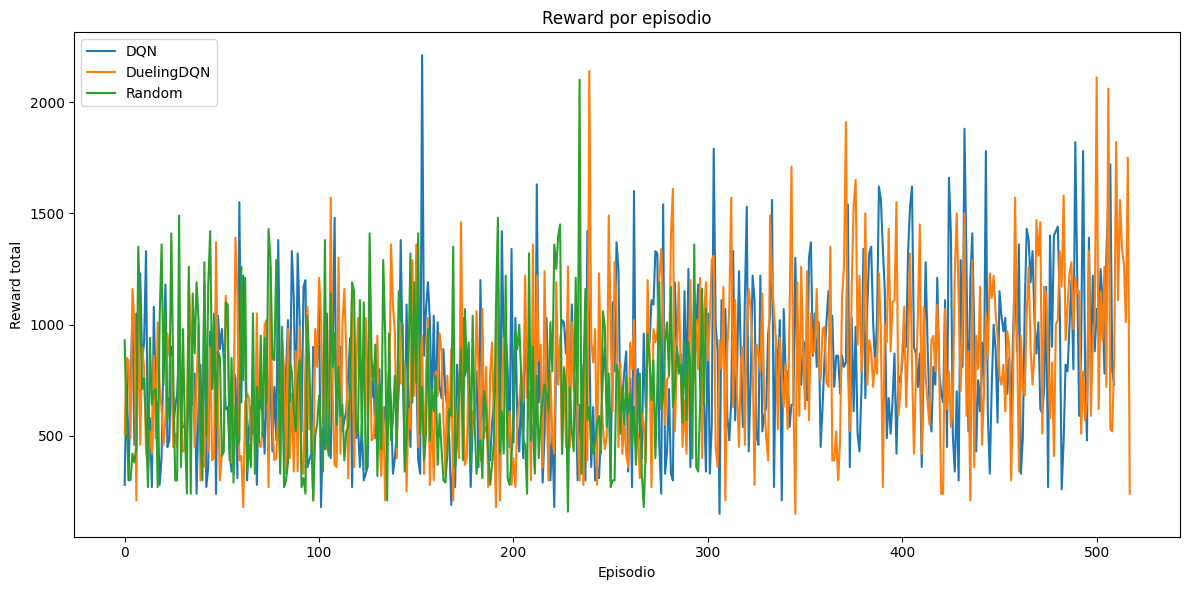

In [11]:
plt.figure(figsize=(12, 6))

# Plot bruto
plt.plot(rewards_dqn, label="DQN")
plt.plot(rewards_dueling, label="DuelingDQN")
plt.plot(rewards_random, label="Random")
plt.xlabel("Episodio")
plt.ylabel("Reward total")
plt.title("Reward por episodio")
plt.legend()
plt.tight_layout()
plt.show()

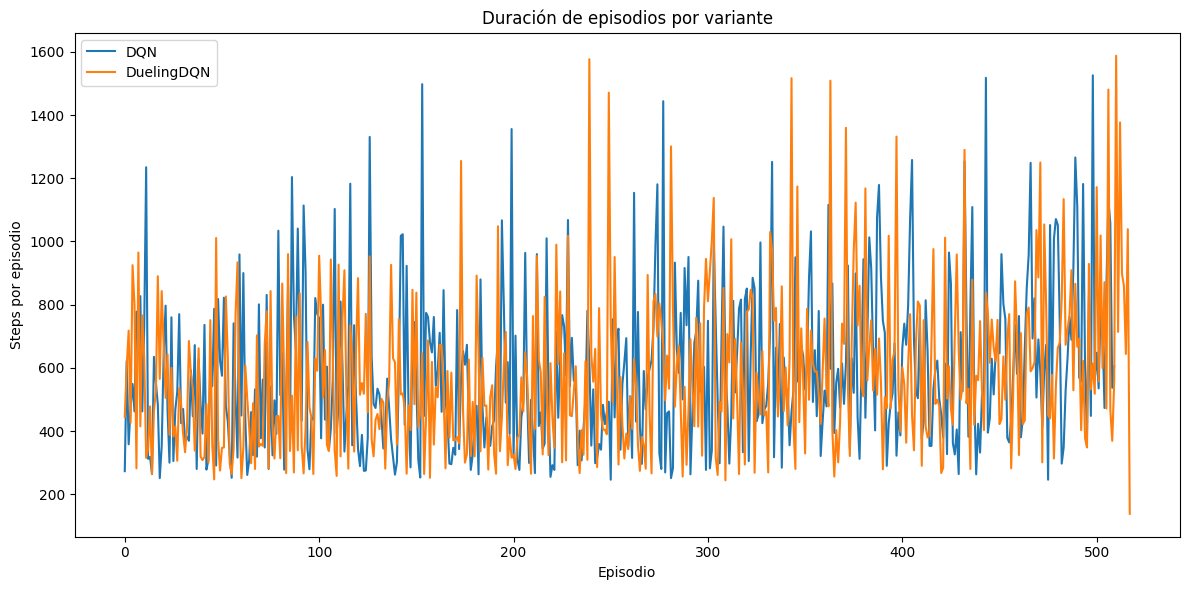

In [12]:
plt.figure(figsize=(12, 6))

plt.plot(len_dqn, label="DQN")
plt.plot(len_dueling, label="DuelingDQN")

plt.xlabel("Episodio")
plt.ylabel("Steps por episodio")
plt.title("Duración de episodios por variante")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def moving_average(x, window):
    x = np.array(x, dtype=np.float32)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window) / window, mode="valid")

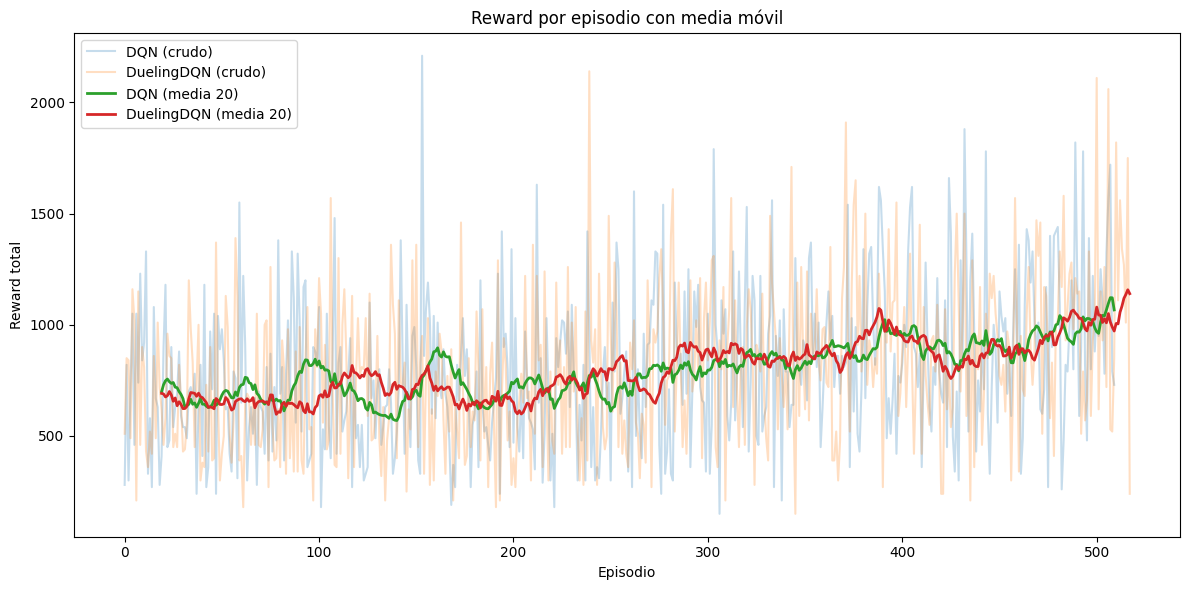

In [14]:
window = 20

ma_dqn = moving_average(rewards_dqn, window)
ma_duel = moving_average(rewards_dueling, window)

plt.figure(figsize=(12, 6))

# curvas “crudas” con poca alpha
plt.plot(rewards_dqn, label="DQN (crudo)", alpha=0.25)
plt.plot(rewards_dueling, label="DuelingDQN (crudo)", alpha=0.25)

# medias móviles desplazadas para que caigan sobre el episodio correcto
episodes_ma = np.arange(window - 1, window - 1 + len(ma_dqn))
plt.plot(episodes_ma, ma_dqn, label=f"DQN (media {window})", linewidth=2)

episodes_ma_duel = np.arange(window - 1, window - 1 + len(ma_duel))
plt.plot(episodes_ma_duel, ma_duel, label=f"DuelingDQN (media {window})", linewidth=2)

plt.xlabel("Episodio")
plt.ylabel("Reward total")
plt.title("Reward por episodio con media móvil")
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación de Modelos

In [15]:
policy = DQNPolicy(model_dqn, device=device, epsilon=0.0)
scores = []
for _ in range(50):
    env_eval = make_galaxian_env(deepmind_wrappers=True, frame_stack=4)
    obs, info = env_eval.reset()
    done = False
    total_r = 0
    while not done:
        action = policy(obs, info, env_eval.action_space)
        obs, r, terminated, truncated, info = env_eval.step(action)
        done = terminated or truncated
        total_r += r
    scores.append(total_r)
    env_eval.close()

print("Mean eval score DQN:", np.mean(scores))

Mean eval score DQN: 1090.0


In [16]:
policy = DQNPolicy(model_dueling, device=device, epsilon=0.0)
scores = []
for _ in range(50):
    env_eval = make_galaxian_env(deepmind_wrappers=True, frame_stack=4)
    obs, info = env_eval.reset()
    done = False
    total_r = 0
    while not done:
        action = policy(obs, info, env_eval.action_space)
        obs, r, terminated, truncated, info = env_eval.step(action)
        done = terminated or truncated
        total_r += r
    scores.append(total_r)
    env_eval.close()

print("Mean eval score DQN:", np.mean(scores))

Mean eval score DQN: 1144.4


Modelo seleccionado: Dueling DQN